<a href="https://colab.research.google.com/github/insoucyant/MachineLearning/blob/main/LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# https://www.youtube.com/watch?v=q_HS4s1L8UI&t=248s
# Import the libraries
import pandas as pd
import numpy as np
from copy import deepcopy as dc
import torch
import torch.nn as nn
#!pip install yfinance
import yfinance as yf
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

In [ ]:
stock = 'Indigo'
Indigo_in = yf.Ticker("INDIGO.NS")
# get stock info
print(Indigo_in.info)

{'address1': 'Emaar Capital Tower-II', 'address2': 'Third Floor Sector-26, Sikanderpur Ghosi Mehrauli - Gurgaon Road', 'city': 'Gurugram', 'zip': '122002', 'country': 'India', 'phone': '91 12 4435 2500', 'fax': '91 12 4406 8536', 'website': 'https://www.goindigo.in', 'industry': 'Airlines', 'industryKey': 'airlines', 'industryDisp': 'Airlines', 'sector': 'Industrials', 'sectorKey': 'industrials', 'sectorDisp': 'Industrials', 'longBusinessSummary': 'InterGlobe Aviation Limited, together with its subsidiaries, engages in the operation of IndiGo airline in India and internationally. The company provides air transportation and pre-flight and post flight ground handling operations which includes passenger and cargo services; and provides related allied services, such as in-flight sales, business of ground handling, and other allied services at the airports. It also offers operating lease for aircraft ground support equipment and aviation training simulation devices. The company was incorpor

In [ ]:
# get historical market data
data_in = Indigo_in.history(period="4400d")
data_in.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2015-11-10 00:00:00+05:30,811.290227,852.717422,804.843903,831.624634,27351793,0.0,0.0
2015-11-13 00:00:00+05:30,870.255186,978.326091,869.307196,951.877136,8446622,0.0,0.0
2015-11-16 00:00:00+05:30,958.418251,985.909972,915.995683,937.515076,3358159,0.0,0.0
2015-11-17 00:00:00+05:30,938.510480,995.295127,925.428225,982.971252,3694092,0.0,0.0
2015-11-18 00:00:00+05:30,964.343224,1013.212175,962.494631,991.266174,3621593,0.0,0.0


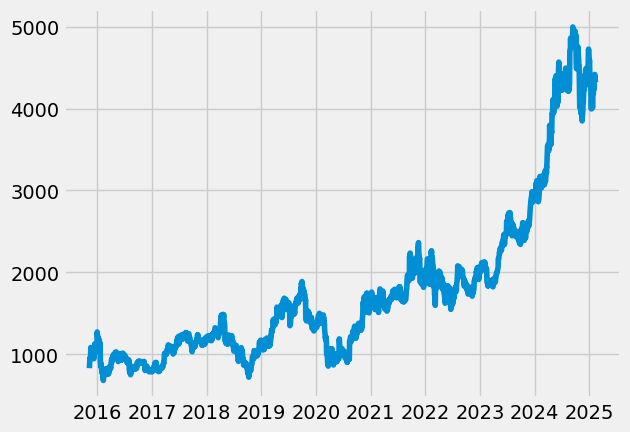

In [ ]:
df_close = data_in[['Close']]
plt.plot(df_close)

In [ ]:
def prepare_data_for_lstm(data, look_back):
  df = dc(data)
  df = df[['Close']]

  for i in range(1, look_back+1):
    df[f'Close(t-{i})'] = df['Close'].shift(i)
    df.dropna(inplace=True)

  return df
LOOKBACK = 7
shifted_df = prepare_data_for_lstm(data_in, LOOKBACK)
shifted_df

,Close,Close(t-1),Close(t-2),Close(t-3),Close(t-4),Close(t-5),Close(t-6),Close(t-7)
Date,,,,,,,,
2015-12-23 00:00:00+05:30,1121.520142,1104.171753,1025.725586,1079.998047,1128.914307,1130.668091,1123.795166,1036.200928
2015-12-24 00:00:00+05:30,1103.887329,1121.520142,1104.171753,1025.725586,1079.998047,1128.914307,1130.668091,1123.795166
2015-12-28 00:00:00+05:30,1132.042725,1103.887329,1121.520142,1104.171753,1025.725586,1079.998047,1128.914307,1130.668091
2015-12-29 00:00:00+05:30,1124.743164,1132.042725,1103.887329,1121.520142,1104.171753,1025.725586,1079.998047,1128.914307
2015-12-30 00:00:00+05:30,1131.189575,1124.743164,1132.042725,1103.887329,1121.520142,1104.171753,1025.725586,1079.998047
...,...,...,...,...,...,...,...,...
2025-02-05 00:00:00+05:30,4415.399902,4345.200195,4393.700195,4324.350098,4227.750000,4293.899902,4282.500000,4175.750000
2025-02-06 00:00:00+05:30,4394.850098,4415.399902,4345.200195,4393.700195,4324.350098,4227.750000,4293.899902,4282.500000
2025-02-07 00:00:00+05:30,4364.549805,4394.850098,4415.399902,4345.200195,4393.700195,4324.350098,4227.750000,4293.899902


In [ ]:
shifted_df_as_np = shifted_df.to_numpy()
X = shifted_df_as_np[:,1:]
y = shifted_df_as_np[:,0]
X.shape, y.shape

((2257, 7), (2257,))

In [ ]:
X = dc(np.flip(X, axis=1))
X

array([[1036.20092773, 1123.79516602, 1130.66809082, ..., 1079.99804688,
        1025.72558594, 1104.17175293],
       [1123.79516602, 1130.66809082, 1128.91430664, ..., 1025.72558594,
        1104.17175293, 1121.5201416 ],
       [1130.66809082, 1128.91430664, 1079.99804688, ..., 1104.17175293,
        1121.5201416 , 1103.8873291 ],
       ...,
       [4293.89990234, 4227.75      , 4324.35009766, ..., 4345.20019531,
        4415.39990234, 4394.85009766],
       [4227.75      , 4324.35009766, 4393.70019531, ..., 4415.39990234,
        4394.85009766, 4364.54980469],
       [4324.35009766, 4393.70019531, 4345.20019531, ..., 4394.85009766,
        4364.54980469, 4325.14990234]])

In [ ]:
split_index = int(len(X)*0.75)
X_train = X[:split_index]
X_test = X[split_index:]
y_train = y[:split_index]
y_test = y[split_index:]
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1692, 7), (565, 7), (1692,), (565,))